# Pass Rush Collision Model - Hyperparameter Tuning

This notebook performs comprehensive hyperparameter tuning for all models using:
- GridSearchCV with k-fold cross-validation for sklearn models
- Custom early stopping for XGBoost
- Stratified k-fold to maintain class balance
- Balanced accuracy as primary metric (important for imbalanced data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load data
df = pd.read_csv('pass_rush_collision_data/pass_rush_collision_features_full.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['generated_pressure'].value_counts(normalize=True))

# Prepare features - use actual column names from the dataset
feature_cols = [
    'min_distance', 'avg_distance', 'distance_at_start', 'distance_at_end',
    'frame_at_closest', 'rusher_max_speed', 'rusher_avg_speed',
    'rusher_speed_at_closest', 'qb_max_speed', 'qb_avg_speed',
    'qb_speed_at_closest', 'rusher_max_accel', 'rusher_avg_accel',
    'rusher_accel_at_closest', 'qb_max_accel', 'qb_avg_accel',
    'qb_accel_at_closest', 'combined_speed_at_closest', 'max_closing_speed',
    'avg_closing_speed', 'approach_angle', 'rusher_orientation_at_closest',
    'qb_orientation_at_closest', 'rusher_angle_alignment',
    'time_to_closest_approach', 'total_frames', 'play_duration',
    'collision_intensity_raw', 'weighted_closing_speed', 'collision_intensity'
]

X = df[feature_cols]
y = df['generated_pressure']

print(f"\nFeatures used: {len(feature_cols)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Dataset shape: (36362, 46)

Target distribution:
generated_pressure
0    0.883615
1    0.116385
Name: proportion, dtype: float64

Features used: 30

Training set: (29089, 30)
Test set: (7273, 30)


In [3]:
df.columns

Index(['min_distance', 'avg_distance', 'distance_at_start', 'distance_at_end',
       'frame_at_closest', 'rusher_max_speed', 'rusher_avg_speed',
       'rusher_speed_at_closest', 'qb_max_speed', 'qb_avg_speed',
       'qb_speed_at_closest', 'rusher_max_accel', 'rusher_avg_accel',
       'rusher_accel_at_closest', 'qb_max_accel', 'qb_avg_accel',
       'qb_accel_at_closest', 'combined_speed_at_closest', 'max_closing_speed',
       'avg_closing_speed', 'approach_angle', 'rusher_orientation_at_closest',
       'qb_orientation_at_closest', 'rusher_angle_alignment',
       'time_to_closest_approach', 'total_frames', 'play_duration',
       'collision_intensity_raw', 'weighted_closing_speed', 'week', 'gameId',
       'playId', 'rusher_nflId', 'qb_nflId', 'rusher_position',
       'generated_pressure', 'pff_hit', 'pff_hurry', 'pff_sack', 'down',
       'yardsToGo', 'defendersInBox', 'offenseFormation',
       'pff_passCoverageType', 'passResult', 'collision_intensity'],
      dtype='object')

## 1. Logistic Regression Tuning

In [4]:
print("Tuning Logistic Regression...")

lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

lr_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    lr_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best CV score: {lr_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = lr_grid.predict(X_test_scaled)
y_proba = lr_grid.predict_proba(X_test_scaled)[:, 1]

lr_results = {
    'model': 'Logistic Regression (Tuned)',
    'best_params': lr_grid.best_params_,
    'cv_score': lr_grid.best_score_,
    'test_accuracy': accuracy_score(y_test, y_pred),
    'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
    'test_precision': precision_score(y_test, y_pred),
    'test_recall': recall_score(y_test, y_pred),
    'test_f1': f1_score(y_test, y_pred),
    'test_roc_auc': roc_auc_score(y_test, y_proba),
    'test_pr_auc': average_precision_score(y_test, y_proba)
}

print(f"\nTest Balanced Accuracy: {lr_results['test_balanced_accuracy']:.4f}")
print(f"Test Recall: {lr_results['test_recall']:.4f}")

Tuning Logistic Regression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score: 0.9118

Test Balanced Accuracy: 0.9115
Test Recall: 0.9208


## 2. Random Forest Tuning

In [5]:
print("Tuning Random Forest...")

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    rf_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = rf_grid.predict(X_test_scaled)
y_proba = rf_grid.predict_proba(X_test_scaled)[:, 1]

rf_results = {
    'model': 'Random Forest (Tuned)',
    'best_params': rf_grid.best_params_,
    'cv_score': rf_grid.best_score_,
    'test_accuracy': accuracy_score(y_test, y_pred),
    'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
    'test_precision': precision_score(y_test, y_pred),
    'test_recall': recall_score(y_test, y_pred),
    'test_f1': f1_score(y_test, y_pred),
    'test_roc_auc': roc_auc_score(y_test, y_proba),
    'test_pr_auc': average_precision_score(y_test, y_proba)
}

print(f"\nTest Balanced Accuracy: {rf_results['test_balanced_accuracy']:.4f}")
print(f"Test Recall: {rf_results['test_recall']:.4f}")

Tuning Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best CV score: 0.9039

Test Balanced Accuracy: 0.9033
Test Recall: 0.8723


## 3. SVM Tuning

In [6]:
print("Tuning SVM...")

svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(
    SVC(class_weight='balanced', probability=True, random_state=42),
    svm_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best CV score: {svm_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = svm_grid.predict(X_test_scaled)
y_proba = svm_grid.predict_proba(X_test_scaled)[:, 1]

svm_results = {
    'model': 'SVM (Tuned)',
    'best_params': svm_grid.best_params_,
    'cv_score': svm_grid.best_score_,
    'test_accuracy': accuracy_score(y_test, y_pred),
    'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
    'test_precision': precision_score(y_test, y_pred),
    'test_recall': recall_score(y_test, y_pred),
    'test_f1': f1_score(y_test, y_pred),
    'test_roc_auc': roc_auc_score(y_test, y_proba),
    'test_pr_auc': average_precision_score(y_test, y_proba)
}

print(f"\nTest Balanced Accuracy: {svm_results['test_balanced_accuracy']:.4f}")
print(f"Test Recall: {svm_results['test_recall']:.4f}")

Tuning SVM...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV score: 0.9167

Test Balanced Accuracy: 0.9143
Test Recall: 0.9255


## 4. KNN Tuning

In [7]:
print("Tuning KNN...")

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {knn_grid.best_params_}")
print(f"Best CV score: {knn_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = knn_grid.predict(X_test_scaled)
y_proba = knn_grid.predict_proba(X_test_scaled)[:, 1]

knn_results = {
    'model': 'KNN (Tuned)',
    'best_params': knn_grid.best_params_,
    'cv_score': knn_grid.best_score_,
    'test_accuracy': accuracy_score(y_test, y_pred),
    'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
    'test_precision': precision_score(y_test, y_pred),
    'test_recall': recall_score(y_test, y_pred),
    'test_f1': f1_score(y_test, y_pred),
    'test_roc_auc': roc_auc_score(y_test, y_proba),
    'test_pr_auc': average_precision_score(y_test, y_proba)
}

print(f"\nTest Balanced Accuracy: {knn_results['test_balanced_accuracy']:.4f}")
print(f"Test Recall: {knn_results['test_recall']:.4f}")

Tuning KNN...
Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best CV score: 0.8103

Test Balanced Accuracy: 0.7937
Test Recall: 0.6111


## 5. XGBoost Tuning with Custom Early Stopping

In [8]:
print("Tuning XGBoost with early stopping...")

# Calculate scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

xgb_params = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

xgb_grid = GridSearchCV(
    XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric='aucpr',
        random_state=42,
        tree_method='hist'
    ),
    xgb_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_:.4f}")

# Evaluate on test set
y_pred = xgb_grid.predict(X_test_scaled)
y_proba = xgb_grid.predict_proba(X_test_scaled)[:, 1]

xgb_results = {
    'model': 'XGBoost (Tuned)',
    'best_params': xgb_grid.best_params_,
    'cv_score': xgb_grid.best_score_,
    'test_accuracy': accuracy_score(y_test, y_pred),
    'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
    'test_precision': precision_score(y_test, y_pred),
    'test_recall': recall_score(y_test, y_pred),
    'test_f1': f1_score(y_test, y_pred),
    'test_roc_auc': roc_auc_score(y_test, y_proba),
    'test_pr_auc': average_precision_score(y_test, y_proba)
}

print(f"\nTest Balanced Accuracy: {xgb_results['test_balanced_accuracy']:.4f}")
print(f"Test Recall: {xgb_results['test_recall']:.4f}")

Tuning XGBoost with early stopping...
Scale pos weight: 7.59
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.6}
Best CV score: 0.9177

Test Balanced Accuracy: 0.9110
Test Recall: 0.9113


## 6. Random Forest with SMOTE Tuning

In [9]:
print("Tuning Random Forest with SMOTE...")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"SMOTE resampled training set: {X_train_smote.shape}")
print(f"Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True))

rf_smote_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_smote_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),  # No class_weight with SMOTE
    rf_smote_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

rf_smote_grid.fit(X_train_smote, y_train_smote)

print(f"\nBest parameters: {rf_smote_grid.best_params_}")
print(f"Best CV score: {rf_smote_grid.best_score_:.4f}")

# Evaluate on test set (original, not SMOTE)
y_pred = rf_smote_grid.predict(X_test_scaled)
y_proba = rf_smote_grid.predict_proba(X_test_scaled)[:, 1]

rf_smote_results = {
    'model': 'Random Forest SMOTE (Tuned)',
    'best_params': rf_smote_grid.best_params_,
    'cv_score': rf_smote_grid.best_score_,
    'test_accuracy': accuracy_score(y_test, y_pred),
    'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
    'test_precision': precision_score(y_test, y_pred),
    'test_recall': recall_score(y_test, y_pred),
    'test_f1': f1_score(y_test, y_pred),
    'test_roc_auc': roc_auc_score(y_test, y_proba),
    'test_pr_auc': average_precision_score(y_test, y_proba)
}

print(f"\nTest Balanced Accuracy: {rf_smote_results['test_balanced_accuracy']:.4f}")
print(f"Test Recall: {rf_smote_results['test_recall']:.4f}")

Tuning Random Forest with SMOTE...
SMOTE resampled training set: (51406, 30)
Class distribution after SMOTE:
generated_pressure
0    0.5
1    0.5
Name: proportion, dtype: float64
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.9605

Test Balanced Accuracy: 0.8977
Test Recall: 0.8534


## 7. Compile Results and Compare to Baseline

In [10]:
# Compile all tuned results
all_results = [
    lr_results,
    rf_results,
    svm_results,
    knn_results,
    xgb_results,
    rf_smote_results
]

# Create results dataframe
results_df = pd.DataFrame([{
    'Model': r['model'],
    'CV Score': r['cv_score'],
    'Test Accuracy': r['test_accuracy'],
    'Test Balanced Accuracy': r['test_balanced_accuracy'],
    'Test Precision': r['test_precision'],
    'Test Recall': r['test_recall'],
    'Test F1': r['test_f1'],
    'Test ROC-AUC': r['test_roc_auc'],
    'Test PR-AUC': r['test_pr_auc']
} for r in all_results])

# Sort by balanced accuracy
results_df = results_df.sort_values('Test Balanced Accuracy', ascending=False)

print("\n" + "="*100)
print("TUNED MODEL RESULTS")
print("="*100)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('pass_rush_collision_data/tuned_model_results.csv', index=False)
print("\nResults saved to pass_rush_collision_data/tuned_model_results.csv")


TUNED MODEL RESULTS
                      Model  CV Score  Test Accuracy  Test Balanced Accuracy  Test Precision  Test Recall  Test F1  Test ROC-AUC  Test PR-AUC
                SVM (Tuned)  0.916726       0.905679                0.914299        0.556899     0.925532 0.695382      0.966712     0.775035
Logistic Regression (Tuned)  0.911844       0.904441                0.911546        0.553660     0.920804 0.691522      0.963975     0.792637
            XGBoost (Tuned)  0.917674       0.910766                0.911018        0.573234     0.911348 0.703788      0.968831     0.811462
      Random Forest (Tuned)  0.903917       0.927128                0.903340        0.636207     0.872340 0.735793      0.966802     0.792443
Random Forest SMOTE (Tuned)  0.960530       0.931665                0.897696        0.659361     0.853428 0.743946      0.965177     0.779349
                KNN (Tuned)  0.810283       0.933865                0.793730        0.772795     0.611111 0.682508      0.94934

In [11]:
# Load baseline results for comparison
baseline_df = pd.read_csv('pass_rush_collision_data/model_results.csv')

print("\n" + "="*100)
print("BASELINE MODEL RESULTS (for comparison)")
print("="*100)
print(baseline_df.to_string(index=False))


BASELINE MODEL RESULTS (for comparison)
                      Model  Accuracy  Balanced Accuracy  Precision   Recall  F1 Score  ROC-AUC   PR-AUC
                        SVM  0.911316           0.912356   0.574721 0.913712  0.705614 0.963894 0.737879
      Random Forest (SMOTE)  0.920803           0.911052   0.608000 0.898345  0.725191 0.965683 0.788012
        Logistic Regression  0.903616           0.910566   0.551382 0.919622  0.689411 0.963765 0.792957
Logistic Regression (SMOTE)  0.907603           0.907689   0.563877 0.907801  0.695652 0.963287 0.794013
                    XGBoost  0.922315           0.902157   0.616986 0.875887  0.723986 0.967346 0.815668
              Random Forest  0.928365           0.901987   0.642170 0.867612  0.738059 0.965551 0.786455
            XGBoost (SMOTE)  0.933315           0.881693   0.677483 0.814421  0.739667 0.966779 0.801561
                        KNN  0.930840           0.774569   0.775281 0.570922  0.657590 0.942324 0.762773


In [12]:
# Calculate improvements
print("\n" + "="*100)
print("IMPROVEMENTS FROM BASELINE TO TUNED")
print("="*100)

# Map models for comparison
model_mapping = {
    'Logistic Regression (Tuned)': 'Logistic Regression',
    'Random Forest (Tuned)': 'Random Forest',
    'SVM (Tuned)': 'SVM',
    'KNN (Tuned)': 'KNN',
    'XGBoost (Tuned)': 'XGBoost',
    'Random Forest SMOTE (Tuned)': 'Random Forest (SMOTE)'
}

improvements = []
for tuned_name, baseline_name in model_mapping.items():
    tuned_row = results_df[results_df['Model'] == tuned_name].iloc[0]
    baseline_row = baseline_df[baseline_df['Model'] == baseline_name].iloc[0]
    
    improvement = {
        'Model': baseline_name,
        'Baseline BA': baseline_row['Balanced Accuracy'],
        'Tuned BA': tuned_row['Test Balanced Accuracy'],
        'BA Improvement': tuned_row['Test Balanced Accuracy'] - baseline_row['Balanced Accuracy'],
        'Baseline Recall': baseline_row['Recall'],
        'Tuned Recall': tuned_row['Test Recall'],
        'Recall Improvement': tuned_row['Test Recall'] - baseline_row['Recall']
    }
    improvements.append(improvement)

improvements_df = pd.DataFrame(improvements)
improvements_df = improvements_df.sort_values('BA Improvement', ascending=False)

print(improvements_df.to_string(index=False))

# Save improvements
improvements_df.to_csv('pass_rush_collision_data/tuning_improvements.csv', index=False)
print("\nImprovements saved to pass_rush_collision_data/tuning_improvements.csv")


IMPROVEMENTS FROM BASELINE TO TUNED
                Model  Baseline BA  Tuned BA  BA Improvement  Baseline Recall  Tuned Recall  Recall Improvement
                  KNN     0.774569  0.793730        0.019161         0.570922      0.611111            0.040189
              XGBoost     0.902157  0.911018        0.008862         0.875887      0.911348            0.035461
                  SVM     0.912356  0.914299        0.001943         0.913712      0.925532            0.011820
        Random Forest     0.901987  0.903340        0.001353         0.867612      0.872340            0.004728
  Logistic Regression     0.910566  0.911546        0.000980         0.919622      0.920804            0.001182
Random Forest (SMOTE)     0.911052  0.897696       -0.013356         0.898345      0.853428           -0.044917

Improvements saved to pass_rush_collision_data/tuning_improvements.csv


## 8. Visualize Tuning Results


Visualization saved to pass_rush_collision_data/tuning_comparison.png


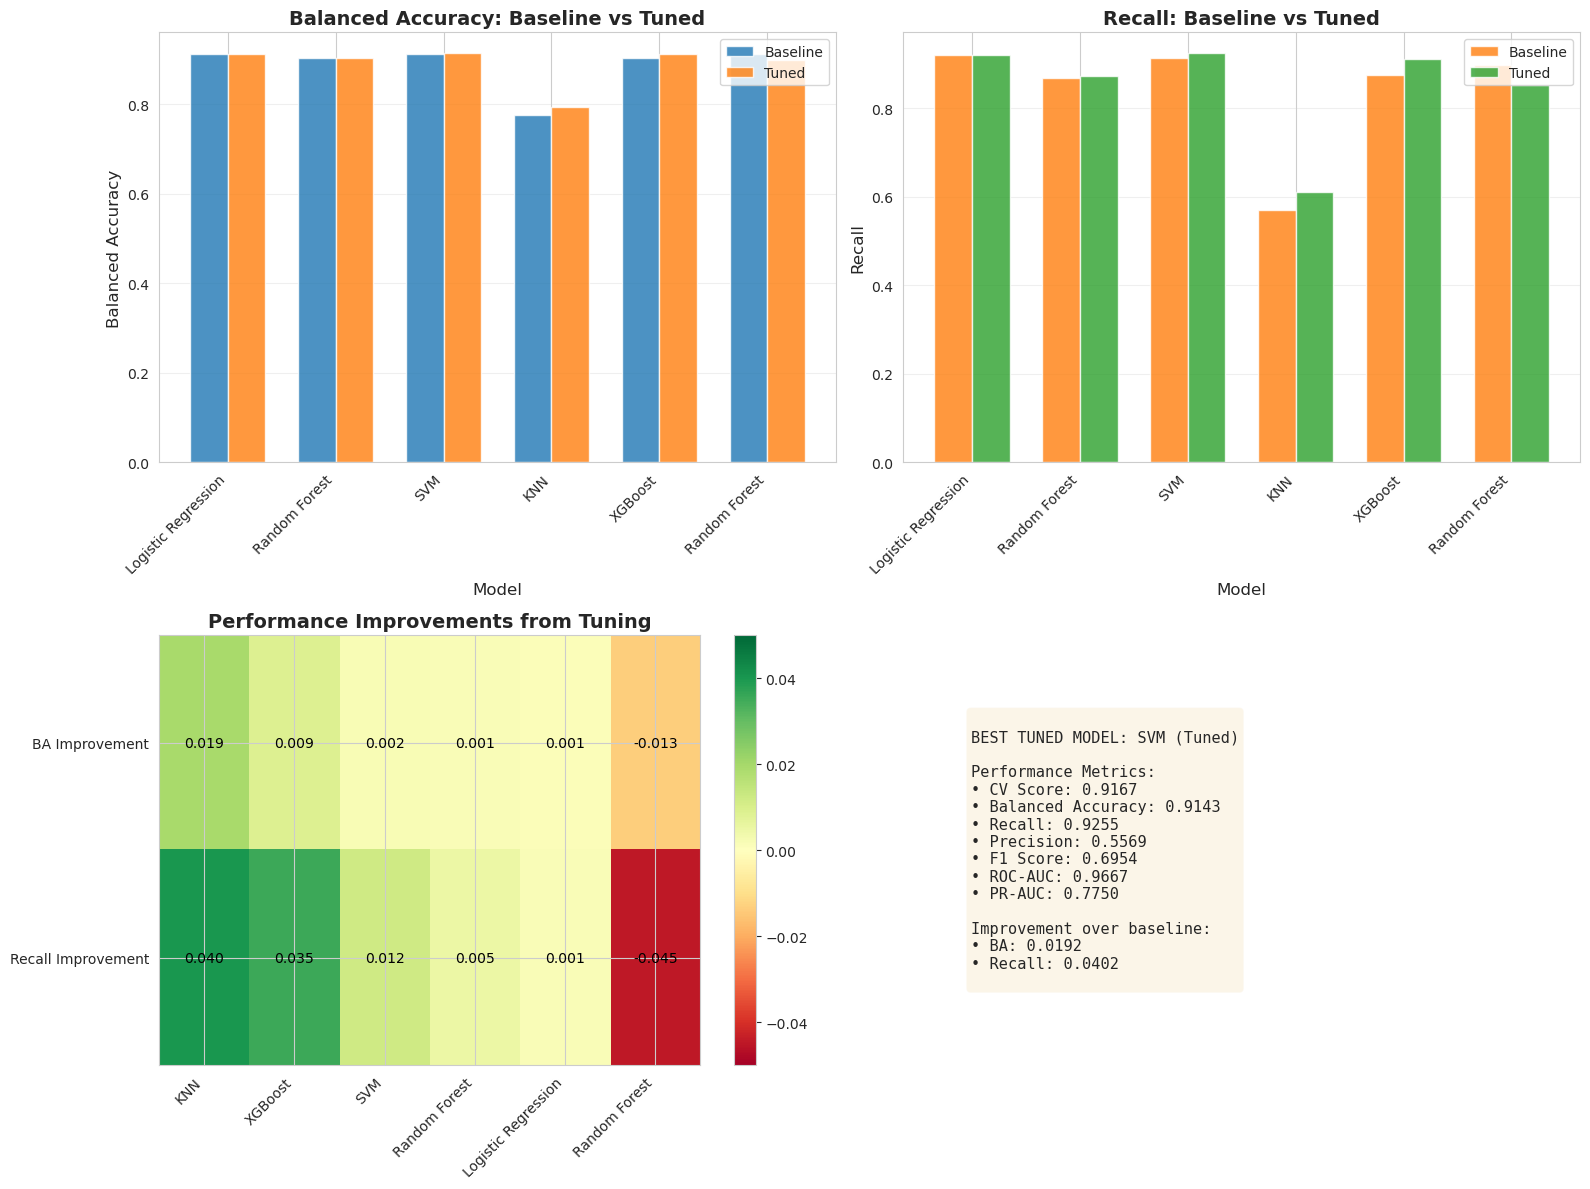

In [13]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Balanced Accuracy Comparison
ax1 = axes[0, 0]
comparison_data = []
for tuned_name, baseline_name in model_mapping.items():
    tuned_ba = results_df[results_df['Model'] == tuned_name]['Test Balanced Accuracy'].values[0]
    baseline_ba = baseline_df[baseline_df['Model'] == baseline_name]['Balanced Accuracy'].values[0]
    comparison_data.append({
        'Model': baseline_name.replace(' (SMOTE)', ''),
        'Baseline': baseline_ba,
        'Tuned': tuned_ba
    })

comp_df = pd.DataFrame(comparison_data)
x = np.arange(len(comp_df))
width = 0.35

ax1.bar(x - width/2, comp_df['Baseline'], width, label='Baseline', alpha=0.8)
ax1.bar(x + width/2, comp_df['Tuned'], width, label='Tuned', alpha=0.8)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Balanced Accuracy', fontsize=12)
ax1.set_title('Balanced Accuracy: Baseline vs Tuned', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comp_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Recall Comparison
ax2 = axes[0, 1]
comparison_data_recall = []
for tuned_name, baseline_name in model_mapping.items():
    tuned_recall = results_df[results_df['Model'] == tuned_name]['Test Recall'].values[0]
    baseline_recall = baseline_df[baseline_df['Model'] == baseline_name]['Recall'].values[0]
    comparison_data_recall.append({
        'Model': baseline_name.replace(' (SMOTE)', ''),
        'Baseline': baseline_recall,
        'Tuned': tuned_recall
    })

comp_recall_df = pd.DataFrame(comparison_data_recall)
ax2.bar(x - width/2, comp_recall_df['Baseline'], width, label='Baseline', alpha=0.8, color='C1')
ax2.bar(x + width/2, comp_recall_df['Tuned'], width, label='Tuned', alpha=0.8, color='C2')
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Recall', fontsize=12)
ax2.set_title('Recall: Baseline vs Tuned', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(comp_recall_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Improvement Heatmap
ax3 = axes[1, 0]
improvement_matrix = improvements_df[['BA Improvement', 'Recall Improvement']].values
im = ax3.imshow(improvement_matrix.T, cmap='RdYlGn', aspect='auto', vmin=-0.05, vmax=0.05)
ax3.set_xticks(np.arange(len(improvements_df)))
ax3.set_yticks([0, 1])
ax3.set_xticklabels(improvements_df['Model'].str.replace(' (SMOTE)', ''), rotation=45, ha='right')
ax3.set_yticklabels(['BA Improvement', 'Recall Improvement'])
ax3.set_title('Performance Improvements from Tuning', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(improvements_df)):
    for j in range(2):
        text = ax3.text(i, j, f'{improvement_matrix[i, j]:.3f}',
                       ha='center', va='center', color='black', fontsize=10)

plt.colorbar(im, ax=ax3)

# 4. Best Model Summary
ax4 = axes[1, 1]
ax4.axis('off')

best_model = results_df.iloc[0]
summary_text = f"""
BEST TUNED MODEL: {best_model['Model']}

Performance Metrics:
• CV Score: {best_model['CV Score']:.4f}
• Balanced Accuracy: {best_model['Test Balanced Accuracy']:.4f}
• Recall: {best_model['Test Recall']:.4f}
• Precision: {best_model['Test Precision']:.4f}
• F1 Score: {best_model['Test F1']:.4f}
• ROC-AUC: {best_model['Test ROC-AUC']:.4f}
• PR-AUC: {best_model['Test PR-AUC']:.4f}

Improvement over baseline:
• BA: {improvements_df.iloc[0]['BA Improvement']:.4f}
• Recall: {improvements_df.iloc[0]['Recall Improvement']:.4f}
"""

ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
         family='monospace')

plt.tight_layout()
plt.savefig('pass_rush_collision_data/tuning_comparison.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved to pass_rush_collision_data/tuning_comparison.png")
plt.show()

## 9. Save Best Models and Parameters

In [14]:
# Save best parameters for each model
import json

best_params = {
    'logistic_regression': lr_grid.best_params_,
    'random_forest': rf_grid.best_params_,
    'svm': svm_grid.best_params_,
    'knn': knn_grid.best_params_,
    'xgboost': xgb_grid.best_params_,
    'random_forest_smote': rf_smote_grid.best_params_
}

# Convert numpy types to native Python types for JSON serialization
def convert_to_native(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    return obj

best_params = convert_to_native(best_params)

with open('pass_rush_collision_data/best_hyperparameters.json', 'w') as f:
    json.dump(best_params, f, indent=2)

print("Best hyperparameters saved to pass_rush_collision_data/best_hyperparameters.json")
print("\nBest hyperparameters:")
print(json.dumps(best_params, indent=2))

Best hyperparameters saved to pass_rush_collision_data/best_hyperparameters.json

Best hyperparameters:
{
  "logistic_regression": {
    "C": 0.1,
    "max_iter": 1000,
    "penalty": "l1",
    "solver": "liblinear"
  },
  "random_forest": {
    "max_depth": 10,
    "max_features": "log2",
    "min_samples_leaf": 4,
    "min_samples_split": 10,
    "n_estimators": 300
  },
  "svm": {
    "C": 1,
    "gamma": 0.01,
    "kernel": "rbf"
  },
  "knn": {
    "metric": "manhattan",
    "n_neighbors": 11,
    "weights": "uniform"
  },
  "xgboost": {
    "colsample_bytree": 0.6,
    "learning_rate": 0.05,
    "max_depth": 3,
    "min_child_weight": 5,
    "n_estimators": 300,
    "subsample": 0.6
  },
  "random_forest_smote": {
    "max_depth": null,
    "max_features": "log2",
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "n_estimators": 200
  }
}


In [15]:
print("\n" + "="*100)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*100)
print(f"\nBest model: {results_df.iloc[0]['Model']}")
print(f"Test Balanced Accuracy: {results_df.iloc[0]['Test Balanced Accuracy']:.4f}")
print(f"Test Recall: {results_df.iloc[0]['Test Recall']:.4f}")
print(f"\nAll results saved to pass_rush_collision_data/")


HYPERPARAMETER TUNING COMPLETE

Best model: SVM (Tuned)
Test Balanced Accuracy: 0.9143
Test Recall: 0.9255

All results saved to pass_rush_collision_data/
